In [1]:
from utils_mcmc import *
import emcee
import utils
import settings

In [8]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=14)
plt.rc('legend', fontsize=13)

## Make colors + noise

In [9]:
earth_comp = utils.get_earth_composition(cloud_percent=50)
true_theta = np.array(list([earth_comp[key]/100 for key in settings.labels]))

print(settings.labels)
print(true_theta)

['cloud', 'snow', 'sand', 'seawater', 'basalt', 'veg']
[0.5    0.0225 0.0105 0.35   0.027  0.09  ]


In [16]:
# important components (we only really care about water, cloud, snow)
selected_idx = [settings.labels.index(component) 
                for component in settings.CLASSIFYING_COMPONENTS]

In [10]:
snr = 50
gaussian_scatter = 1/snr

ytrue = eval_model(true_theta)
yerr = ytrue*gaussian_scatter*np.random.standard_normal(ytrue.shape)
yobs = ytrue + yerr

## Estimate with MLE

In [13]:
from scipy.optimize import minimize

loglikelihood_min_wrapper = lambda *args: -log_likelihood(*args)
initial = utils.uniform_unity(size=(1,6))[0]
bnds = [[0,1]]*6

def constr(x):
    return np.sum(x) - 1

constrs ={'type':'eq', 'fun': constr}

soln = minimize(loglikelihood_min_wrapper, initial, bounds=bnds, constraints=constrs, args=(yobs, yerr))
print(soln)

     fun: 0.7164074104594271
     jac: array([-0.19401149, -0.17728451, -0.18846323, -0.1826856 ,  0.24183001,
        4.58784604])
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.03456014e-01, 6.09015712e-02, 5.78158657e-02, 3.77826549e-01,
       2.63446743e-16, 3.38998368e-15])


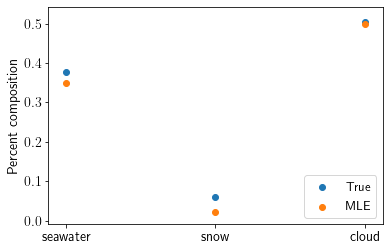

In [41]:
plt.scatter(settings.CLASSIFYING_COMPONENTS, soln.x[selected_idx], label="True")
plt.scatter(settings.CLASSIFYING_COMPONENTS, true_theta[selected_idx], label="MLE")
plt.legend(frameon=True, loc="lower right")
plt.ylabel("Percent composition");

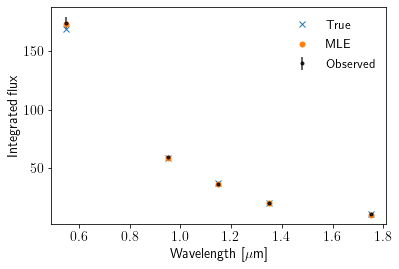

In [46]:
wavelengths = good_filters_values + settings.FILTER_SIZE/2

plt.errorbar(wavelengths, yobs, yerr=yerr, fmt=".k", capsize=0, alpha=0.8, label="Observed")
plt.plot(wavelengths, ytrue, 'x', label="True")
plt.plot(wavelengths, eval_model(soln.x), '.', markersize=10, label="MLE")

plt.legend(frameon=False)
plt.ylabel("Integrated flux")
plt.xlabel(r"Wavelength [$\mu$m]");

## MCMC

In [47]:
pos = utils.uniform_unity(size=(settings.MCMC_N_WALKERS, len(settings.labels)))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(yobs, yerr)
)

sampler.run_mcmc(pos, settings.MCMC_CHAINS_LEN, progress=True, skip_initial_state_check=True);

100%|██████████| 10000/10000 [10:30<00:00, 15.86it/s]


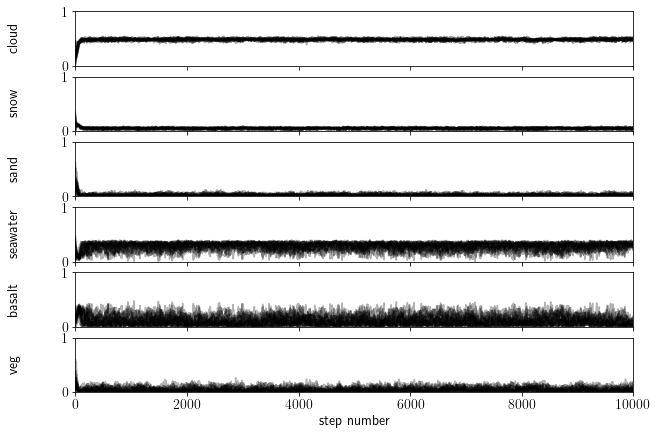

In [49]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylim(0,1)
    ax.set_ylabel(settings.labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [58]:
# get burn-in and thinning from ACT
tau = sampler.get_autocorr_time()[selected_idx]
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)[:,selected_idx]

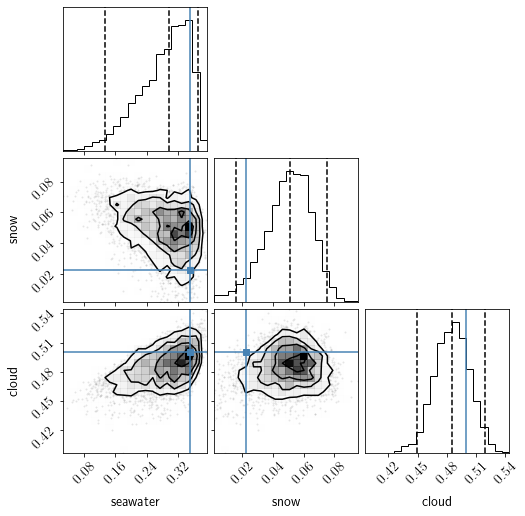

In [60]:
import corner

fig = corner.corner(
    samples, labels=settings.CLASSIFYING_COMPONENTS, truths=true_theta[selected_idx],
    quantiles=[0.025, 0.5, 0.975],

);

In [34]:
print(labels)
print(true_theta)

['cloud', 'snow', 'sand', 'seawater', 'basalt', 'veg']
[0.5    0.0225 0.0105 0.35   0.027  0.09  ]


In [63]:
from IPython.display import display, Math

for i in range(3):
    mcmc = np.percentile(samples[:, i], [2.5, 50, 97.5])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], settings.CLASSIFYING_COMPONENTS[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [64]:
lower, median, upper = np.percentile(samples, [2.5, 50, 97.5], axis=0)

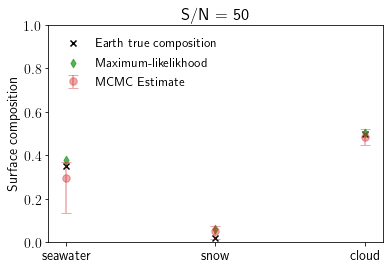

In [68]:
plt.scatter(settings.CLASSIFYING_COMPONENTS, true_theta[selected_idx], color='k', marker='x', label='Earth true composition')

plt.scatter(settings.CLASSIFYING_COMPONENTS, soln.x[selected_idx], color='tab:green', 
            marker='d', label='Maximum-likelikhood', alpha=0.8)

plt.errorbar(settings.CLASSIFYING_COMPONENTS, median, 
             yerr=(median-lower, upper-median), 
             marker='.', color='tab:red', linestyle='', alpha=0.4, markersize=15,
             capsize=5, 
             label='MCMC Estimate')

plt.ylabel('Surface composition')
plt.title(f'S/N = {snr}')
plt.ylim(0,1)
# plt.grid(axis='x')
plt.legend(frameon=False, loc='upper left');

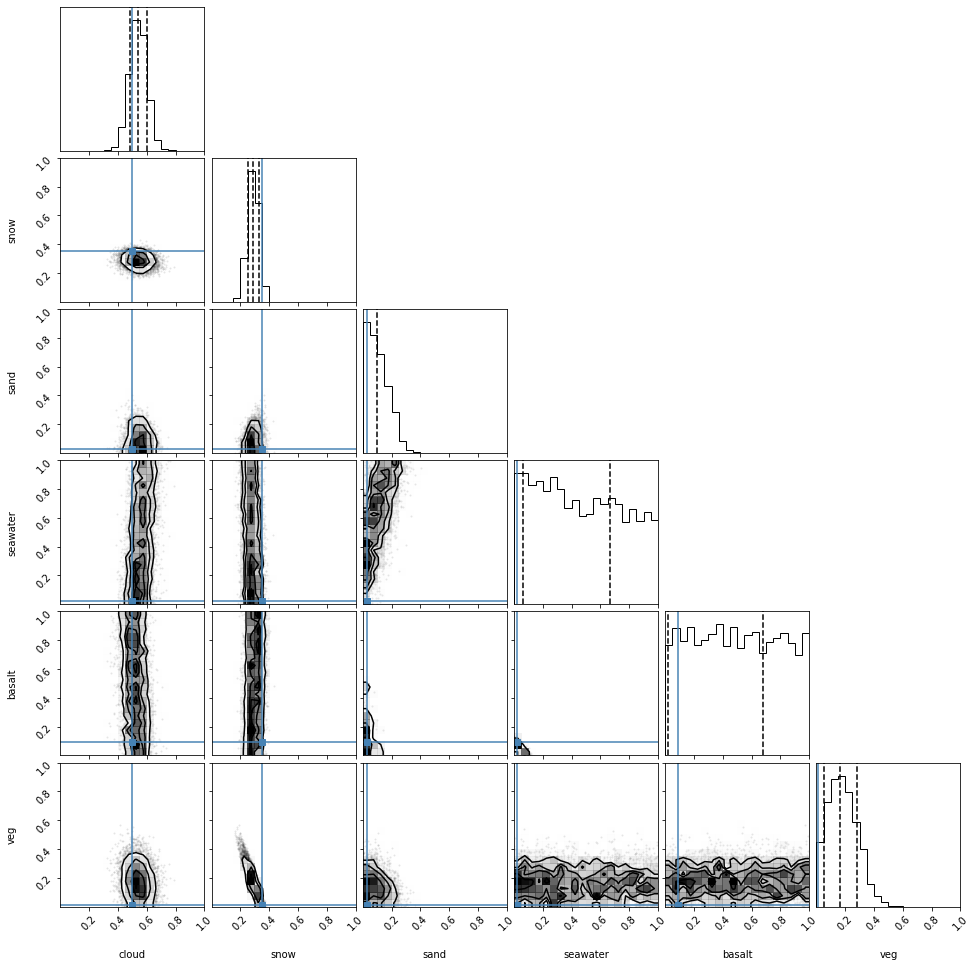

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=true_theta,
    range=([[0,1]]*6), 
    quantiles=[0.16, 0.5, 0.84],
);

array([0.5   , 0.35  , 0.027 , 0.0225, 0.09  , 0.0105])

In [68]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>